In [1]:
import PIL
from PIL import Image
import numpy as np
import torch
from torch import autocast
from slugify import slugify
from time import time

from diffusers import DDIMScheduler, StableDiffusionImg2ImgPipeline
from diffusion_utils import stable_diffusion_preprocess_image

In [2]:
device     = 'cuda'
model_path = 'models/stable-diffusion-v1.5'

torch.cuda.empty_cache()
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
model = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    scheduler=scheduler,
    revision='fp16',
    torch_dtype=torch.float16,
)
model.to('cuda')
model.enable_attention_slicing()

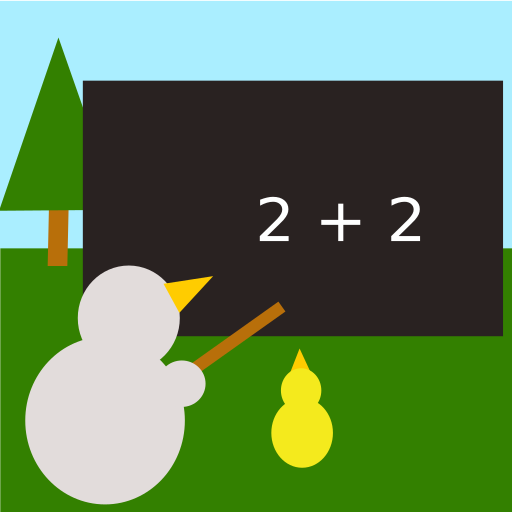

In [3]:
# load image from disk
start_image_preprocessed = stable_diffusion_preprocess_image('image_to_image_start_example.png')
start_image_preprocessed

In [4]:
generator = torch.Generator(device=device).manual_seed(42)

  0%|          | 0/40 [00:00<?, ?it/s]

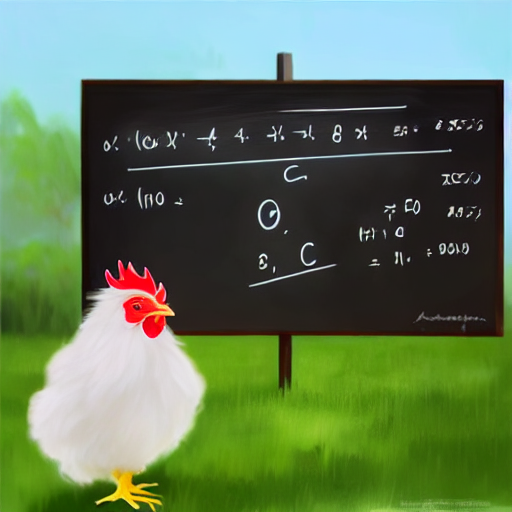

  0%|          | 0/40 [00:00<?, ?it/s]

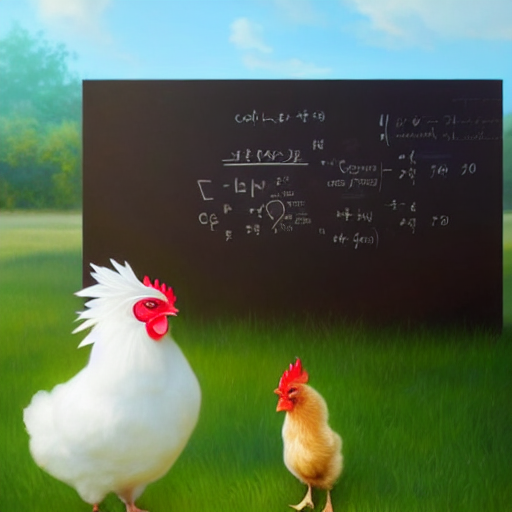

  0%|          | 0/40 [00:00<?, ?it/s]

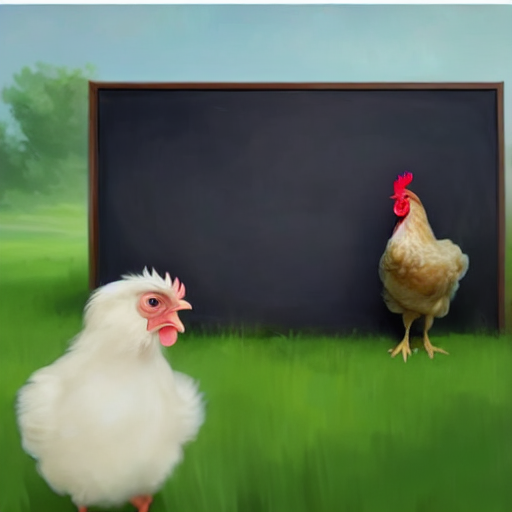

  0%|          | 0/40 [00:00<?, ?it/s]

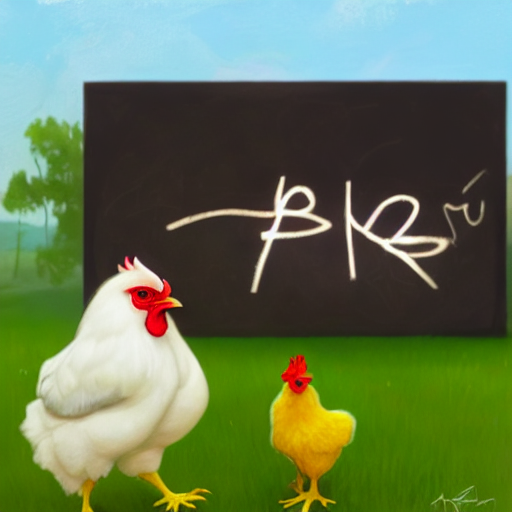

  0%|          | 0/40 [00:00<?, ?it/s]

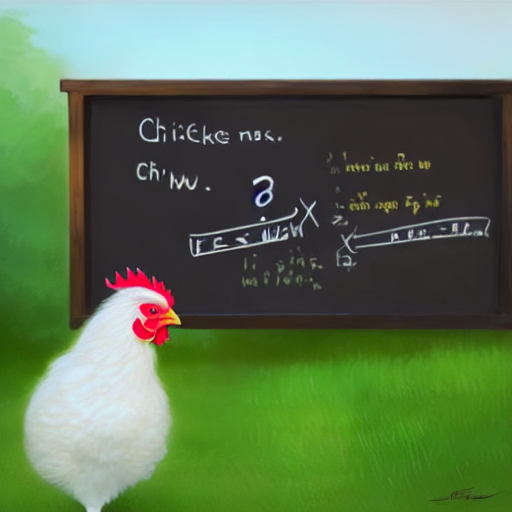

In [5]:
prompt = 'a chicken explaining to chicks, equations on the blackboard, elegant, intricate, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha'
repetitions = 5

with autocast('cuda'):
    for r in range(repetitions):
        image = model(
            prompt = prompt,
            init_image = start_image_preprocessed,
            num_inference_steps=50,
            strength = 0.8, # 0 = no noise, 1 = max noise
            guidance_scale = 7.5,# how much to rely on the textual prompt
            generator = generator,
        )
        image = image['sample'][0]
        image.show()
        image.save(f'images/{time()}_{slugify(prompt[:100])}.png')